### dataset:

**Lens**
```
/data/inspur_disk03/userdir/wangcx/lens_cx
change to /data/inspur_disk03/userdir/wangcx/lens_cx_add_bass @0822

```
**non-lens**
```
/data/inspur_disk03/userdir/wangcx/decals_non_lens_BASS_resulation/PSF/101t101_good
/data/inspur_disk03/userdir/wangcx/decals_non_lens_BASS_resulation/COMP/101t101_good
/data/inspur_disk03/userdir/wangcx/decals_non_lens_BASS_resulation/DEV/101t101_good
/data/inspur_disk03/userdir/wangcx/decals_non_lens_BASS_resulation/REX/101t101_good
```

In [2]:
import astropy.io.fits as fits
import numpy as np
import os
import glob
import tqdm
import matplotlib.pylab as plt

In [3]:
def check_dir(path):
    if not os.path.isdir(path):
        print('mkdir: ', path)
        os.makedirs(path)

In [4]:
DirBase = "/data/inspur_disk03/userdir/wangcx"
OutBase = "/data/dell5/userdir/maotx/Lens/0822"
check_dir(OutBase)
data_shape = [101,101,3]

In [5]:
fp_lens = glob.glob(os.path.join(DirBase,'lens_cx_add_bass/cutout*.fits'))
fp_nlens = glob.glob(os.path.join(DirBase,'decals_non_lens_BASS_resulation/*/101t101_good/cutout*.fits'))

In [6]:
fp_lens=[i.replace(DirBase+'/','') for i in fp_lens]
fp_nlens=[i.replace(DirBase+'/','') for i in fp_nlens]

In [7]:
def show(data):
    fig, axes = plt.subplots(1,4,figsize=(4.5*4,4.5))
    ax = axes[0]
    print(data.shape)
    ax.imshow(data[:,:,0])
    ax.invert_yaxis()
    ax = axes[1]
    ax.imshow(data[:,:,1])
    ax.invert_yaxis()
    ax = axes[2]
    ax.imshow(data[:,:,2])
    ax.invert_yaxis()
    ax = axes[3]
    ax.imshow(data)
    ax.invert_yaxis()

In [8]:
def preprocess(func):
    def wrapper(*args, **kwargs):
        fp = args[0]
        data = func(fp).astype(np.float32)
        cut = 100
        #---------------------------
        m = data.mean(axis=(1,2))[:,None,None]
        s = data.std(axis=(1,2))[:,None,None]
        data -= m
        data /= s
        data = data.transpose(1,2,0)
        #data = np.clip(data,-cut,cut)
        #---------------------------
        return data
    return wrapper

In [9]:
@preprocess
def readdata(fp):
    with fits.open(fp) as hdu:
        data = hdu[0].data
    return data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(101, 101, 3)
(101, 101, 3)
(101, 101, 3)
(101, 101, 3)


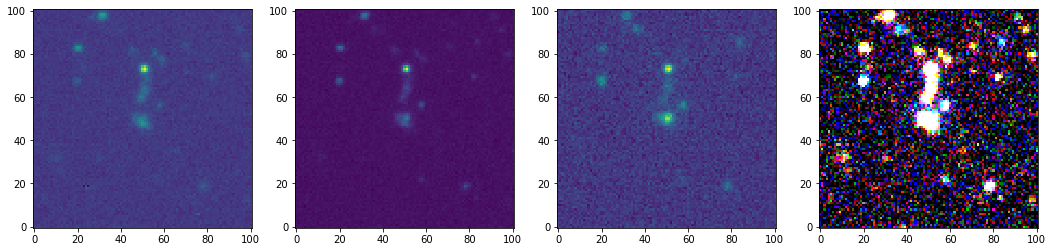

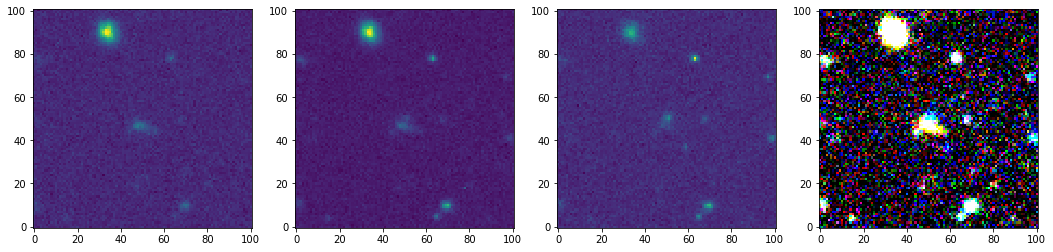

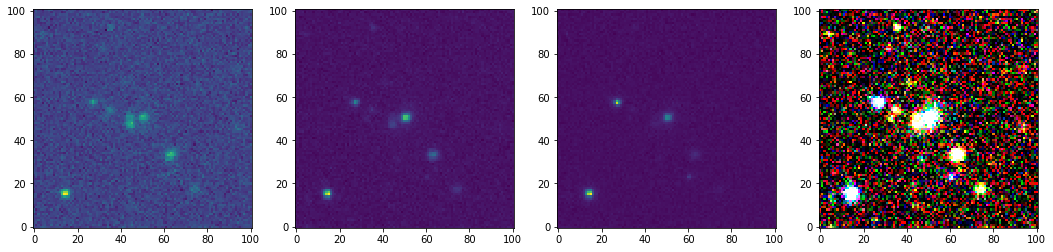

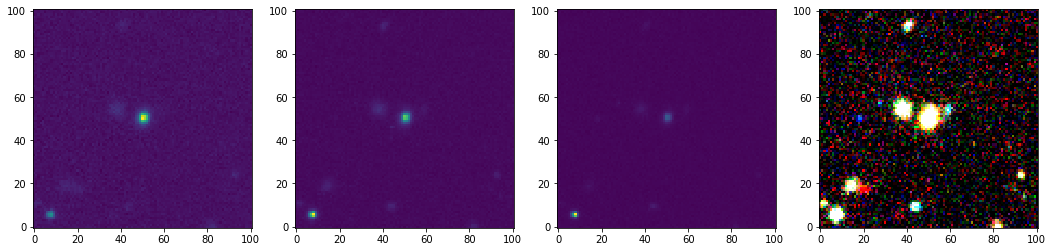

In [10]:
data = readdata(os.path.join(DirBase,fp_lens[0]))
show(data)
data = readdata(os.path.join(DirBase,fp_lens[2]))
show(data)
data = readdata(os.path.join(DirBase,fp_lens[4]))
show(data)
data = readdata(os.path.join(DirBase,fp_nlens[0]))
show(data)

### select training sample

In [10]:
frac = np.array([0.8,0.9,1.0])

In [11]:
frac = np.array([0.9,1.0,1.0])

In [12]:
dt = np.dtype([('label', np.int32, 1), ('image', np.float32, data_shape)])

In [13]:
def sel(size, frac):
    random_ind = np.random.permutation(np.arange(size))
    ind_dataset = np.ceil(frac*size).astype(np.int32)
    ind_train = random_ind[:ind_dataset[0]]
    ind_valid = random_ind[ind_dataset[0]:ind_dataset[1]]
    ind_test = random_ind[ind_dataset[1]:ind_dataset[2]]
    return ind_train, ind_valid, ind_test

In [14]:
def get_filename(fps, frac):
    index = sel(len(fps), frac)
    fp_tr = [fps[i] for i in index[0]]
    fp_va = [fps[i] for i in index[1]]
    fp_te = [fps[i] for i in index[2]]
    return fp_tr, fp_va, fp_te

In [15]:
path = os.path.join(OutBase, 'data')
check_dir(path)
FNs = {}
for fps, ns in zip([fp_lens, fp_nlens], ['lens', 'nlens']):
    fp_tr, fp_va, fp_te = get_filename(fps, frac)
    FNs[ns] = [fp_tr, fp_va, fp_te]
    with open(os.path.join(path, 'filename_{}_tr'.format(ns)), 'w') as f:
        for i in fp_tr:
            f.writelines(i+'\n')
    with open(os.path.join(path, 'filename_{}_va'.format(ns)), 'w') as f:
        for i in fp_va:
            f.writelines(i+'\n')
    with open(os.path.join(path, 'filename_{}_te'.format(ns)), 'w') as f:
        for i in fp_te:
            f.writelines(i+'\n')

In [15]:
fn_train = np.hstack([FNs[i][0] for i in ['lens', 'nlens']])
nl1 = np.hstack([FNs[i][0] for i in ['lens']]).shape[0]
nl0 = np.hstack([FNs[i][0] for i in ['nlens']]).shape[0]
print(nl1, nl0)
data_tr = np.empty([len(fn_train)], dtype=dt)
data_tr['label'][:nl1] = 1
data_tr['label'][nl1:nl1+nl0] = 0
for i in tqdm.tqdm(range(len(fn_train))):
    data_tr['image'][i] = readdata(os.path.join(DirBase, fn_train[i]))

  0%|          | 12/19031 [00:00<02:42, 116.77it/s]

312 18719


100%|██████████| 19031/19031 [03:29<00:00, 90.90it/s] 


In [16]:
fn_valid = np.hstack([FNs[i][1] for i in ['lens', 'nlens']])
nl1 = np.hstack([FNs[i][1] for i in ['lens']]).shape[0]
nl0 = np.hstack([FNs[i][1] for i in ['nlens']]).shape[0]
print(nl1, nl0)
data_va = np.empty([len(fn_valid)], dtype=dt)
data_va['label'][:nl1] = 1
data_va['label'][nl1:nl1+nl0] = 0
for i in tqdm.tqdm(range(len(fn_valid))):
    data_va['image'][i] = readdata(os.path.join(DirBase, fn_valid[i]))

  1%|          | 18/2113 [00:00<00:12, 171.70it/s]

34 2079


100%|██████████| 2113/2113 [00:17<00:00, 120.52it/s]


In [17]:
fn_test = np.hstack([FNs[i][2] for i in ['lens', 'nlens']])
nl1 = np.hstack([FNs[i][2] for i in ['lens']]).shape[0]
nl0 = np.hstack([FNs[i][2] for i in ['nlens']]).shape[0]
print nl1, nl0
data_te = np.empty([len(fn_test)], dtype=dt)
data_te['label'][:nl1]=1
data_te['label'][nl1:nl1+nl0]=0
remove = []
for i in tqdm.tqdm(range(len(fn_test))):
    data_te['image'][i] = readdata(os.path.join(DirBase,fn_test[i]))

  1%|▏         | 29/2107 [00:00<00:08, 246.58it/s]

28 2079


100%|██████████| 2107/2107 [00:23<00:00, 91.43it/s]


### oversampling for training and validation sets:

In [17]:
def oversampling(sample):
    index = np.arange(sample.shape[0])
    dstar_ind = index[sample['label']==1]
    sstar_ind = index[sample['label']==0]
    resample_ind = dstar_ind[np.random.randint(0, dstar_ind.shape[0]-1, sstar_ind.shape[0])]
    ind_new = np.hstack([sstar_ind,resample_ind])
    ind_new = ind_new[np.random.permutation(np.arange(ind_new.shape[0]))]
    return ind_new

In [19]:
reind = oversampling(data_tr)
train_dataset = data_tr[reind]
reind = oversampling(data_va)
valid_dataset = data_va[reind]

for a test case: 

In [1]:
test_dataset = data_va
np.save(os.path.join(OutBase,'data/test.npy'), test_dataset)

NameError: name 'data_va' is not defined

In [18]:
test_dataset = data_te
print(train_dataset.shape, valid_dataset.shape, test_dataset.shape)

NameError: name 'data_te' is not defined

In [20]:
np.save(os.path.join(OutBase,'data/training.npy'), train_dataset)
#np.save(os.path.join(OutBase,'data/test.npy'), test_dataset)
np.save(os.path.join(OutBase,'data/valid.npy'), valid_dataset)